# Example: Auto-Vectorization for RISC-V Vector-Extension using LLVM

TODO

## Supported components

**Models:** Any (`aww` and `resnet` used below)

**Frontends:** Any (`tflite` used below)

**Frameworks/Backends:** Any (`tvmaotplus` used below)

**Platforms/Targets:** Any platforms and targets supporting the `vext` or `auto_vectorize` feature (`spike` used below)

**Features:** `vext` or `auto_vectorize` feature have to be enabled/installed

**Toolchains:** `llvm` only (RVV GCC is __not__ stable for Zve32x)

## Prerequisites

Set up MLonmCU as usual, i.e. initializa an environment and install all required dependencies. Feel free to use the following minimal `environment.yml.j2` template:

```yaml
---
home: "{{ home_dir }}"
logging:
  level: DEBUG
  to_file: false
  rotate: false
cleanup:
  auto: true
  keep: 10
paths:
  deps: deps
  logs: logs
  results: results
  plugins: plugins
  temp: temp
  models:
    - "{{ home_dir }}/models"
    - "{{ config_dir }}/models"
repos:
  tvm:
    url: "https://github.com/apache/tvm.git"
    ref: de6d8067754d746d88262c530b5241b5577b9aae
  spike:
    url: "https://github.com/riscv-software-src/riscv-isa-sim.git"
    ref: 0bc176b3fca43560b9e8586cdbc41cfde073e17a
  spikepk:
    url: "https://github.com/riscv-software-src/riscv-pk.git"
    ref: 7e9b671c0415dfd7b562ac934feb9380075d4aa2
  mlif:
    url: "https://github.com/tum-ei-eda/mlonmcu-sw.git"
    ref: 4b9a32659f7c5340e8de26a0b8c4135ca67d64ac
frameworks:
  default: tvm
  tvm:
    enabled: true
    backends:
      default: tvmaotplus
      tvmaotplus:
        enabled: true
        features: []
    features: []
frontends:
  tflite:
    enabled: true
    features: []
toolchains:
  gcc: true
  llvm: true
platforms:
  mlif:
    enabled: true
    features:
      auto_vectorize: true
targets:
  default: spike
  spike:
    enabled: true
    features:
      vext: false
      pext: false
```

Do not forget to set your `MLONMCU_HOME` environment variable first if not using the default location!

## Usage

The following examples use the embedded vextor extension (Zve32x/f) instead of the full vector extension since it is more suitable for MCU-type devices and  suffices for running quantized ML models.

*Warning:* Since Instruction-Set-Simulators (ISS) are used for the following experimenents, we only consider instruction counts instead of real cycle counts (CPI=1). Of course is is not realistic that an actual implementation using VLEN=4096 can finish every operation in a single cycle.

### A) Command Line Interface

As an example, we run `tvmaotplus` backend with two different models on the `spike` target. Since using RISC-V GCC for vectorization seems to lead to some issues, we tell MLonMCU to use LLVM instead (`--config mlif.toolchain=llvm`).

To figure out if auto-vectorization works we first use the `--config vext.vlen=128 --config vext.embedded=1 --feature-gen _ --feature-gen auto_vectorize feature vext` flags.

In [6]:
!python -m mlonmcu.cli.main flow run aww resnet -b tvmaotplus -t spike --config mlif.toolchain=llvm \
        --config vext.vlen=128 --config vext.embedded=1 \
        --feature-gen _ --feature-gen auto_vectorize vext

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-341]  Processing stage LOAD
INFO - [session-341]  Processing stage BUILD
INFO - [session-341]  Processing stage COMPILE
INFO - [session-341]  Processing stage RUN
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-341] Done processing runs
INFO - Report:
   Session  Run   Model Frontend Framework     Backend Platform Target    Cycles  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data                Features                                             Config Postprocesses Comment
0      341    0     aww   tflite       tvm  tvmaotplus     mlif  spike  25158835     136862     123328          63268     73578        16      2512              120816                      []  {'tflite.use_inout_data': False, 'tflite.visua...            []       -
1      341    1     aww   tflite       tv

To do some actual comparions, lets run these benchmarks for a set of different VLEN value using several `--config-gen` arguments:

In [9]:
!python -m mlonmcu.cli.main flow run aww resnet -b tvmaotplus -t spike --config mlif.toolchain=llvm \
        --config vext.embedded=1 --feature auto_vectorize --feature vext \
        --config-gen vext.vlen=128 --config-gen vext.vlen=256 --config-gen vext.vlen=512 \
        --config-gen vext.vlen=1024 --config-gen vext.vlen=2048 --config-gen vext.vlen=4096

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-344]  Processing stage LOAD
INFO - [session-344]  Processing stage BUILD
INFO - [session-344]  Processing stage COMPILE
INFO - [session-344]  Processing stage RUN
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-344] Done processing runs
INFO - Report:
    Session  Run   Model Frontend Framework     Backend Platform Target    Cycles  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data                Features                                             Config Postprocesses Comment
0       344    0     aww   tflite       tvm  tvmaotplus     mlif  spike   9460297     188700     123328          63256    125428        16      2512              120816  [vext, auto_vectorize]  {'tflite.use_inout_data': False, 'tflite.visua...            []       -
1       344    1     aww   tflite      

Since the used VLEN is part of the "Config" column is it not shown above. We can fix that using some postprocesses:

In [12]:
!python -m mlonmcu.cli.main flow run aww resnet -b tvmaotplus -t spike --config mlif.toolchain=llvm \
        --config vext.embedded=1 --feature auto_vectorize --feature vext \
        --config-gen vext.vlen=128 --config-gen vext.vlen=256 --config-gen vext.vlen=512 \
        --config-gen vext.vlen=1024 --config-gen vext.vlen=2048 --config-gen vext.vlen=4096 \
        --postprocess config2cols --postprocess filter_cols --postprocess rename_cols \
        --config rename_cols.mapping="{'config_vext.vlen': 'VLEN'}" \
        --config filter_cols.keep="Model,Cycles,VLEN"

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-346]  Processing stage LOAD
INFO - [session-346]  Processing stage BUILD
INFO - [session-346]  Processing stage COMPILE
INFO - [session-346]  Processing stage RUN
INFO - [session-346]  Processing stage POSTPROCESS
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-346] Done processing runs
INFO - Report:
     Model    Cycles
0      aww   9460297
1      aww   6665329
2      aww   5583814
3      aww   4904091
4      aww   4665951
5      aww   4970511
6   resnet  57781484
7   resnet  44163303
8   resnet  38158478
9   resnet  36342423
10  resnet  36136404
11  resnet  36178322


It might be interesting to visualize the above results in a graph. Check out the "Python Scripting" example below which also covers that.

### B) Python Scripting

Using the Python Scripting API add more degrees of freedom defining benchmarks and allows more powerful trnaformating of the generated results. The following section visualizes the effect of RVV auto-vectorization applied by the LLVM toolchain for different vector lengths.

In [15]:
from tempfile import TemporaryDirectory
from pathlib import Path
import pandas as pd

from mlonmcu.context.context import MlonMcuContext
from mlonmcu.session.run import RunStage

Benchmark Configuration

In [23]:
FRONTEND = "tflite"
MODELS = ["aww", "resnet"]
BACKEND = "tvmaotplus"
PLATFORM = "mlif"
TARGET = "spike"
POSTPROCESSES = ["config2cols", "rename_cols", "filter_cols"]
CONFIG = {
    "mlif.toolchain": "llvm",
    "vext.embedded": True,
    "rename_cols.mapping": {"config_vext.vlen": "VLEN"},
    "filter_cols.keep": ["Model", "Cycles", "VLEN"]
}

Initialize and run a multiple benchmarks:

In [24]:
with MlonMcuContext() as context:
    session = context.create_session()
    for model in MODELS:
        def helper(session, vlen=0):
            cfg = CONFIG.copy()
            if vlen > 0:
                cfg["vext.vlen"] = vlen
            run = session.create_run(config=cfg)
            if vlen > 0:
                run.add_features_by_name(["vext", "auto_vectorize"], context=context)
            run.add_frontend_by_name(FRONTEND, context=context)
            run.add_model_by_name(model, context=context)
            run.add_backend_by_name(BACKEND, context=context)
            run.add_platform_by_name(PLATFORM, context=context)
            run.add_target_by_name(TARGET, context=context)
            run.add_postprocesses_by_name(POSTPROCESSES)
        for vlen in [0, 128, 256, 512, 1024, 2048, 4096]:
            helper(session, vlen)
    session.process_runs(context=context)
    report = session.get_reports()
report.df

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - Loading extensions.py (User)
INFO - [session-350] Processing all stages
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-350] Done processing runs
INFO - [session-350] Processing all stages
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-350] Done processing runs


,Model,Cycles,VLEN
0,aww,25158835,NaN
1,aww,9460297,128.0
2,aww,6665329,256.0
3,aww,5583814,512.0
4,aww,4904091,1024.0
5,aww,4665951,2048.0
6,aww,4970511,4096.0
7,resnet,83103375,NaN
8,resnet,57781485,128.0
9,resnet,44163303,256.0


We can transform the dataframe using pandas as follows:

In [66]:
df = report.df
df.fillna(0, inplace=True)
df.set_index('VLEN', inplace=True)
df.index = df.index.map(int).map(str)
firsts = (df.groupby('Model')['Cycles'].transform('first'))
df["Factor"] = 1 / (df.Cycles / firsts)
df

,Model,Cycles,Factor
VLEN,,,
0,aww,25158835,1.000000
128,aww,9460297,2.659413
256,aww,6665329,3.774583
512,aww,5583814,4.505672
1024,aww,4904091,5.130173
2048,aww,4665951,5.392006
4096,aww,4970511,5.061619
0,resnet,83103375,1.000000
128,resnet,57781485,1.438235


Finally, we can visualize the achieved speedup for the considered vector lengths:

Model
aww       AxesSubplot(0.125,0.11;0.775x0.77)
resnet    AxesSubplot(0.125,0.11;0.775x0.77)
Name: Factor, dtype: object

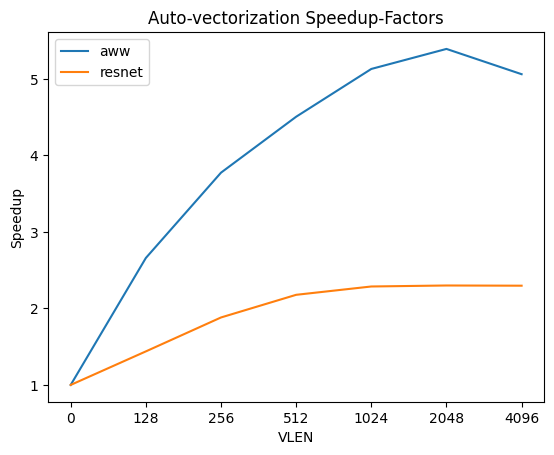

In [67]:
df.groupby('Model')['Factor'].plot(legend=True, title="Auto-vectorization Speedup-Factors", ylabel="Speedup")

The achievable speedup depends heavily on the workload (used model) and too large vector registers might degrade the performance as well in the end.